In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from aux_funct import ewma_volatility, HoLee, plot_ho_lee_lattice

In [5]:
# Parameters

N = 25*12 # horizonte temporal en cantidad de meses
dt = 1/12 # paso temporal en años
r0 = 0.04761 # tasa inicial


In [6]:
sigma = ewma_volatility('r1m.txt')
sigma = sigma[-1] # usando volatilidad spot

r = HoLee(sigma = sigma, N = N, dt = dt, r0 = r0, df_filename='df.txt')

# plot_ho_lee_lattice(r = r, sigma = sigma)
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [7]:
sigma

0.0016835430755297832

In [8]:
r.T[:,0]

array([ 0.04761   ,  0.04701986,  0.04624359,  0.04570168,  0.04303161,
        0.04263968,  0.04242869,  0.04099377,  0.04066158,  0.04034701,
        0.03866261,  0.03833434,  0.03800918,  0.0365541 ,  0.03622201,
        0.03589124,  0.03556148,  0.03523288,  0.03490543,  0.03470661,
        0.03438246,  0.03405953,  0.03373781,  0.03341733,  0.03309811,
        0.03367343,  0.03336354,  0.03305502,  0.03274789,  0.03244216,
        0.03213785,  0.03183497,  0.03153355,  0.0312336 ,  0.03093513,
        0.03063816,  0.03034271,  0.02956058,  0.02926432,  0.02896959,
        0.0286764 ,  0.02838479,  0.02809475,  0.02780632,  0.02751951,
        0.02723435,  0.02695084,  0.02666902,  0.0263889 ,  0.02591017,
        0.02563184,  0.02535527,  0.02508046,  0.02480744,  0.02453624,
        0.02426687,  0.02399935,  0.02373372,  0.02347   ,  0.02320821,
        0.02294837,  0.02179826,  0.02153465,  0.02127297,  0.02101324,
        0.0207555 ,  0.02049976,  0.02024606,  0.01999442,  0.01

In [11]:
def pascal_factors_funct(m: int) -> np.array:
    pascal_factors = np.zeros([m,m])
    for j in range(m):
        for i in range(m):
            if i == 0 or i==j:
                pascal_factors[i][j] = 1
            else:
                pascal_factors[i][j] = pascal_factors[i][j-1] + pascal_factors[i-1][j-1]
    return pascal_factors

def esperanza(m: int, r: np.array, pascal_factors: np.array) -> np.array:
    expected_value = np.zeros(m+1)
    for t in range(m+1):
        expected_value[t] = 2 ** (-t)*np.dot(r[:,t], pascal_factors[:,t])
    return expected_value

In [12]:

from matplotlib.ticker import PercentFormatter

def plot_ho_lee_lattice(
    r: np.ndarray,
    dt: float,
    sigma: float,
    title: str = "Lattice de Ho–Lee",
    mostrar_esperanza: bool = False
):
    """
    r : matriz triangular (n+1 x n+1) con r[i,j] definido para i<=j (NaN fuera)
        r en DECIMAL (p.ej. 0.0184 = 1.84%)
    dt : tamaño del paso en años (ej: 1/12 si mensuales, 0.25 si trimestrales)
    sigma : volatilidad anual (decimal)
    mostrar_esperanza : si True, traza E[r_t] usando pascal_factors_funct y esperanza
                        (deben existir en el namespace)
    """
    n = r.shape[0] - 1
    T = np.arange(n + 1) * dt  # eje en años

    fig, ax = plt.subplots(figsize=(10, 5))

    # --- aristas del lattice ---
    for j in range(n):
        for i in range(j + 1):
            if np.isfinite(r[i, j]) and np.isfinite(r[i, j+1]):
                ax.plot([T[j], T[j+1]], [r[i, j], r[i, j+1]], color="red", lw=0.8)
            if np.isfinite(r[i, j]) and np.isfinite(r[i+1, j+1]):
                ax.plot([T[j], T[j+1]], [r[i, j], r[i+1, j+1]], color="red", lw=0.8)

    # --- nodos ---
    for j in range(n + 1):
        y = r[:j+1, j]
        x = np.full(j + 1, T[j])
        ax.plot(x, y, "o", ms=2, color="black")

    # --- esperanza por tenor (opcional) ---
    if mostrar_esperanza:
        m = n  # nº total de pasos (meses si dt=1/12)
        # llamamos a TUS funciones (se asume que están definidas en tu entorno)
        pascal_factors = pascal_factors_funct(m+1)
        mu = esperanza(m, r, pascal_factors)  # vector de largo m+1
        ax.plot(T, mu, lw=2.2, color="blue", label="Valor esperado en plazo t")
        ax.legend(loc="upper left")

    # formato ejes
    ax.set_xlim(T[0], T[-1])
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # r en %
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Plazo (años)")
    ax.set_ylabel("Tasa")

    ax.set_title(f"{title} calibrado a mercado 15 septiembre de 2025 con volatilidad σ = {round(sigma*100*100,2)}bps")
    plt.savefig("holee_ewma.png", dpi=300, bbox_inches="tight", facecolor="white")
    plt.tight_layout()
    plt.show()

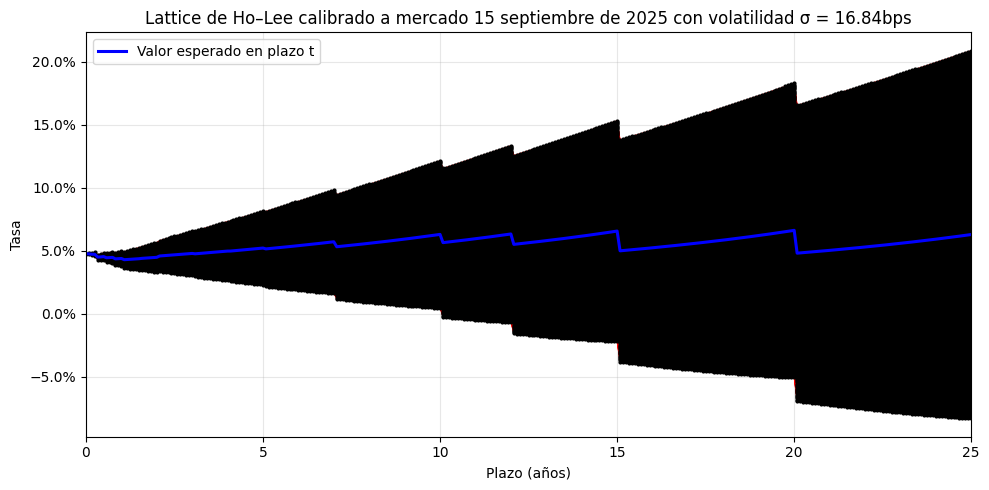

In [13]:
plot_ho_lee_lattice(r, dt=1/12, sigma=sigma, mostrar_esperanza=True)